In [1]:

from diskcache import Cache
import os
from Utils.data_manager import DataManager
from Utils.models import FMNIST_Net
from Clients.training import Training
import copy
import torch
from torch import nn
from Utils.analytics import Analytics
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class FULDebug:
    def __init__(self, cache, breakpoint, num_parties, num_fl_rounds):
        
        cache["breakpoint"] = breakpoint
        self.num_parties = num_parties
        self.num_fl_rounds = num_fl_rounds
        self.cache = cache
    
    def average_selected_models(self, selected_parties, party_models):
        with torch.no_grad():
            sum_vec = nn.utils.parameters_to_vector(party_models[selected_parties[0]].parameters())
            if len(selected_parties) > 1:
                for i in range(1,len(selected_parties)):
                    sum_vec += nn.utils.parameters_to_vector(party_models[selected_parties[i]].parameters())
                sum_vec /= len(selected_parties)

            model = copy.deepcopy(party_models[0])
            nn.utils.vector_to_parameters(sum_vec, model.parameters())
        return model.state_dict()
    
    def aggregate(self, client_models, current_model=None):
        selected_parties = [i for i in range(self.num_parties)]
        aggregated_model_state_dict = self.average_selected_models(selected_parties, client_models)
        return aggregated_model_state_dict 
    
    def partiesStart(self, trainloader_lst, testloader, client_to_be_erased=100, dataType="FMNIST"):

        num_fl_rounds = self.num_fl_rounds
        num_parties = self.num_parties
        initial_model = FMNIST_Net()
        model_dict = copy.deepcopy(initial_model.state_dict())
        for round_num in range(num_fl_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
            for party_id in range(num_parties):

                if party_id == client_to_be_erased:
                    client_models.append(FMNIST_Net())
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=1)
                    model_update, party_loss = local_training.train(model=model, 
                                                trainloader=trainloader_lst[party_id], 
                                                criterion=None, opt=None, dataType=dataType)

                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
            ######################################################################  
            current_model_state_dict = self.aggregate(client_models=client_models, current_model=current_model)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = FMNIST_Net()
            eval_model.load_state_dict(current_model_state_dict)
            clean_acc = local_training.evaluate(testloader, eval_model)
            # clean_accuracy[fusion_key][round_num] = clean_acc        
            self.cache[f"client_models"] = client_models
            self.cache[f"global_models"] = current_model_state_dict
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')
            # print(self.cache.get(f"client_models_{round_num}"))

    # Function to compute class-wise accuracy
    def compute_classwise_metrics(self, model, test_loader):
        class_correct = defaultdict(int)
        class_total = defaultdict(int)
        
        model.eval()
        
        with torch.no_grad():
            for data, labels in test_loader:
                if data.dim() == 5:  # If the image has an extra dimension, squeeze it
                    data = data.squeeze(1)  # Remove the extra dimension
                    
                # Check if the input tensor has the correct shape for CIFAR-10
                if data.shape[1] == 32:  # Indicates the channel dimension is incorrectly set as 32
                    # Permute from [batch_size, height, width, channels] to [batch_size, channels, height, width]
                    data = data.permute(0, 3, 1, 2)
                    
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                
                # Update class-wise correct/total counts
                for label, prediction in zip(labels, predicted):
                    class_total[label.item()] += 1
                    if label.item() == prediction.item():
                        class_correct[label.item()] += 1
        
        # Compute class-wise accuracies
        class_accuracies = {cls: class_correct[cls] / class_total[cls] if class_total[cls] > 0 else 0
                            for cls in class_total}
        
        return class_accuracies, class_total

    # Function to identify classes impacted by unlearning
    def identify_affected_classes(self, global_model_before, global_model_after, test_loader, threshold=0.05):
        """
        Identify the classes that are significantly impacted after unlearning client 0.
        
        :param global_model_before: The global model before unlearning.
        :param global_model_after: The global model after unlearning.
        :param test_loader: The test data loader.
        :param threshold: The threshold to consider a class significantly impacted.
        :return: A list of impacted classes.
        """
        # Compute class-wise accuracy before and after unlearning
        before_class_accuracies, _ = self.compute_classwise_metrics(global_model_before, test_loader)
        after_class_accuracies, _ = self.compute_classwise_metrics(global_model_after, test_loader)
    
        impacted_classes = []
    
        # Compare class accuracies before and after unlearning
        for cls in before_class_accuracies:
            accuracy_drop = before_class_accuracies[cls] - after_class_accuracies[cls]
            if accuracy_drop > threshold:
                impacted_classes.append(cls)
    
        return impacted_classes

    def calculate_class_weights(self, global_model_before, global_model_after, test_loader, impacted_classes):
        """
        Calculate class weights based on the accuracy difference before and after unlearning.
        
        :param global_model_before: Global model before unlearning.
        :param global_model_after: Global model after unlearning.
        :param test_loader: DataLoader for the test data.
        :param impacted_classes: List of impacted classes.
        :return: Dictionary with class indices as keys and weights as values.
        """
        # Compute class-wise accuracies before and after unlearning
        class_accuracies_before, _ = self.compute_classwise_metrics(global_model_before, test_loader)
        class_accuracies_after, _ = self.compute_classwise_metrics(global_model_after, test_loader)
        
        # Calculate the absolute difference in accuracy for each impacted class
        accuracy_diffs = {class_idx: abs(class_accuracies_before[class_idx] - class_accuracies_after[class_idx])
                          for class_idx in impacted_classes}
        
        # Normalize the differences to sum to 1 (to be used as weights)
        total_diff = sum(accuracy_diffs.values())
        class_weights = {class_idx: (diff / total_diff) for class_idx, diff in accuracy_diffs.items()} if total_diff > 0 else {class_idx: 1/len(impacted_classes) for class_idx in impacted_classes}
        
        # Print class weights for reference
        for class_idx, weight in class_weights.items():
            print(f"Class {class_idx} Weight: {weight:.4f}")
        
        return class_weights

    
    def select_clients_to_fix_bias(self, clients_models, impacted_classes, test_loader, global_model, global_model_before, global_model_after, num_clients=3, lambda_penalty=0.1):
        """
        Select clients that contribute the most to the affected classes with automated class weighting and regularization.
        
        :param clients_models: List of models for remaining clients.
        :param impacted_classes: List of classes impacted by unlearning client 0.
        :param test_loader: DataLoader for the test data.
        :param global_model: Global model to compute deviations for regularization.
        :param global_model_before: Global model before unlearning.
        :param global_model_after: Global model after unlearning.
        :param num_clients: Number of clients to select for fixing the bias.
        :param lambda_penalty: Regularization term to penalize clients with large deviations from global performance.
        :return: Tuple of (list of selected client indices, list of selected client models).
        """
        # Automatically assign class weights based on accuracy impact
        class_weights = self.calculate_class_weights(global_model_before, global_model_after, test_loader, impacted_classes)
    
        client_contributions = []
        
        # Compute global model's class-wise accuracy for regularization
        global_class_accuracies, _ = self.compute_classwise_metrics(global_model, test_loader)
        
        # Compute class-wise accuracy for each client
        for client_idx, client_model in enumerate(clients_models):
            class_accuracies, _ = self.compute_classwise_metrics(client_model, test_loader)
            
            # Calculate the weighted contribution of this client to the impacted classes
            contribution = sum((class_accuracies[class_idx] * class_weights[class_idx]) for class_idx in impacted_classes)
            
            # Compute the regularization term: deviation from the global model
            deviation_penalty = sum(abs(class_accuracies[class_idx] - global_class_accuracies[class_idx]) for class_idx in impacted_classes)
            
            # Final score: contribution minus regularization penalty
            final_contribution = contribution - lambda_penalty * deviation_penalty
            
            client_contributions.append((client_idx, client_model, final_contribution))
        
        # Sort clients by their final contribution score
        client_contributions.sort(key=lambda x: x[2], reverse=True)
        
        # Select top clients to fix the bias
        selected_clients = client_contributions[:num_clients]
        
        # Extract client indices and models for the selected clients
        selected_client_indices = [client_idx for client_idx, _, _ in selected_clients]
        selected_client_models = [client_model for _, client_model, _ in selected_clients]
        
        # Print selected clients and their contributions
        for client_idx, _, contribution in selected_clients:
            print(f"Selected Client {client_idx} with Contribution: {contribution:.4f}")
        
        # Return both selected client indices and models
        return selected_client_models, selected_client_indices


    def unlearnedModelAggregationWithSelectedClients(self, trainloader_lst, testloader, unlearned_model, num_rounds=10, client_to_be_erased=100, select_clients_method='random', select_num_clients=6):
    
        num_parties = self.num_parties
        initial_model = FMNIST_Net()
        current_model_state_dict = copy.deepcopy(unlearned_model.state_dict())  
        initial_model.load_state_dict(current_model_state_dict)  
        model_dict = copy.deepcopy(initial_model.state_dict())

        model_before = self.cache.get('initial_model')
        model_before.load_state_dict(self.cache.get('global_models'))
        model_before.eval()
        
        model_after = self.cache.get('initial_model')
        model_after.load_state_dict(self.cache.get("unlearned_model").state_dict())
        model_after.eval()
        
        client_model = self.cache.get('initial_model')
        client_model.load_state_dict(self.cache.get("client_models")[0].state_dict())
        client_model.eval()
        
        global_model_accuracies = []
        for round_num in range(num_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
    
            for party_id in range(num_parties):
                if party_id == client_to_be_erased:
                    client_models.append(FMNIST_Net())  # Placeholder for unlearned client
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=1)
                    model_update, party_loss = local_training.train(model=model, 
                                                    trainloader=trainloader_lst[party_id], 
                                                    criterion=None, opt=None, dataType="CIFAR")
    
                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
    
            ###################### Client Selection ###############################
            impacted_classes = self.identify_affected_classes(model_before, model_after, testDataloader, threshold=0.05)
            selected_client_models, selected_client_indices = self.select_clients_to_fix_bias(client_models, impacted_classes, testDataloader, model_before, model_before, model_after, num_clients=5)
            print(selected_client_models)
    
            #######################################################################
            # Aggregate only the selected client models
            current_model_state_dict = self.unlearnAggregate(client_models=selected_client_models, client_to_be_erased=client_to_be_erased)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = FMNIST_Net()
            eval_model.load_state_dict(current_model_state_dict)
    
            clean_acc = local_training.evaluate(testloader, eval_model)
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')
            global_model_accuracies.append(clean_acc)
            self.cache[f"unlearning_client_models"] = client_models
            self.cache[f"unlearning_global_models"] = current_model_state_dict
        return global_model_accuracies
    
    def unlearnAggregate(self, client_models, client_to_be_erased):
        selected_parties = [i for i in range(len(client_models))]
        aggregated_model_state_dict = self.average_selected_models(selected_parties, client_models)
        return aggregated_model_state_dict
    
    def unlearnedModelAggregation(self, trainloader_lst, testloader, unlearned_model, num_rounds=10, client_to_be_erased=100):

        num_parties = self.num_parties
        initial_model = FMNIST_Net()
        current_model_state_dict = copy.deepcopy(unlearned_model.state_dict())  
        initial_model.load_state_dict(current_model_state_dict)  
        model_dict = copy.deepcopy(initial_model.state_dict())
        for round_num in range(num_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
            for party_id in range(num_parties):

                if party_id == client_to_be_erased:
                    client_models.append(FMNIST_Net())
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=1)
                    model_update, party_loss = local_training.train(model=model, 
                                                trainloader=trainloader_lst[party_id], 
                                                criterion=None, opt=None, dataType="FMNIST")

                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
            ######################################################################  
            current_model_state_dict = self.unlearnAggregate(client_models=client_models, client_to_be_erased=client_to_be_erased)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = FMNIST_Net()
            eval_model.load_state_dict(current_model_state_dict)
            clean_acc = local_training.evaluate(testloader, eval_model)
            # clean_accuracy[fusion_key][round_num] = clean_acc      
            self.cache[f"unlearning_client_models"] = client_models
            self.cache[f"unlearning_global_models"] = current_model_state_dict
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')

    def compute_weight_contribution(self, global_model, client_updates, selected_client_idx):
        """
        Compute the influence of each client's weight contribution to the global model.

        :param global_model: The baseline global model (PyTorch model)
        :param client_updates: List of model updates from each client (list of state_dicts)
        :param selected_client_idx: Index of the client whose contribution you want to analyze
        :return: Difference between the global model's weights with and without the selected client's contribution
        """
        # Compute the average weight update with all clients
        num_clients = len(client_updates)
        avg_update = {key: torch.zeros_like(val) for key, val in client_updates[0].state_dict().items()}

        for update in client_updates:
            for key in update.state_dict():
                avg_update[key] += update.state_dict()[key] / num_clients

        # Compute the average weight update without the selected client
        avg_update_without_client = {key: torch.zeros_like(val) for key, val in client_updates[0].state_dict().items()}

        for i, update in enumerate(client_updates):
            if i == selected_client_idx:
                continue  # Skip the selected client
            for key in update.state_dict():
                avg_update_without_client[key] += update.state_dict()[key] / (num_clients - 1)

        # Calculate the difference in the global model's weights
        weight_difference = {key: avg_update[key] - avg_update_without_client[key] for key in avg_update}

        return weight_difference

    def compute_weight_norm_difference(self, weight_difference):
        """
        Computes the norm of the weight differences to quantify the impact.

        :param weight_difference: Dictionary containing weight differences for each layer
        :return: Dictionary with norms for each layer
        """
        norm_diff = {}
        for layer, diff in weight_difference.items():
            norm_diff[layer] = torch.norm(diff).item()
        return norm_diff
    
    def analyze_class_bias(self, global_model, weight_difference, num_classes=10):
        """
        Analyzes the class-specific impact of removing a client's weight contribution.

        :param global_model: The baseline global model (PyTorch model)
        :param weight_difference: Difference in weights with and without the selected client's contribution
        :param num_classes: Number of classes in the dataset (e.g., 10 for MNIST)
        :return: Impact on each class based on output layer weight differences
        """
        output_layer_key = None

        # Identify the output layer by checking for the appropriate layer name
        for key in weight_difference.keys():
            if 'weight' in key and weight_difference[key].shape[0] == num_classes:
                output_layer_key = key
                break

        if output_layer_key is None:
            raise ValueError("Could not identify the output layer in the model.")

        # Analyze the impact on each class
        class_impact = torch.norm(weight_difference[output_layer_key], dim=1).tolist()
        return class_impact

    def summarize_and_print_results(slef, norm_diff, class_impact):
        """
        Summarizes and prints the results of the weight differences and class impacts.

        :param norm_diff: Dictionary containing the norms of weight differences for each layer
        :param class_impact: List containing the impact on each class
        """
        print("=== Summary of Weight Differences by Layer ===")
        print(f"{'Layer':<20} {'Norm Difference':>20}")
        print("-" * 40)
        
        for layer, norm in norm_diff.items():
            print(f"{layer:<20} {norm:>20.6f}")
        
        print("\n=== Impact on Each Class ===")
        print(f"{'Class':<10} {'Impact':>10}")
        print("-" * 25)
        
        for class_idx, impact in enumerate(class_impact):
            print(f"Class {class_idx:<5} {impact:>10.6f}")
        
        print("\n=== Analysis ===")
        
        # Find the class with the maximum and minimum impact
        max_impact_class = max(range(len(class_impact)), key=lambda i: class_impact[i])
        min_impact_class = min(range(len(class_impact)), key=lambda i: class_impact[i])
        
        print(f"The highest impact is on Class {max_impact_class} with an impact value of {class_impact[max_impact_class]:.6f}.")
        print(f"The lowest impact is on Class {min_impact_class} with an impact value of {class_impact[min_impact_class]:.6f}.")

        # Determine which layers are most and least affected
        most_affected_layer = max(norm_diff, key=norm_diff.get)
        least_affected_layer = min(norm_diff, key=norm_diff.get)
        
        print(f"The most affected layer is '{most_affected_layer}' with a norm difference of {norm_diff[most_affected_layer]:.6f}.")
        print(f"The least affected layer is '{least_affected_layer}' with a norm difference of {norm_diff[least_affected_layer]:.6f}.")
        print("\nThis analysis suggests that removing the selected client's contribution mainly affects the above class and layer.")



/Users/wathsara/.pyenv/versions/3.9.6/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize the cache
cache = Cache('./cache1', size_limit=5 * 10**9)
initial_model = FMNIST_Net()
cache["initial_model"] = initial_model
breakpoint =  {"round": 5, "status": False}
# Initialize the MNIST loader
loader = DataManager(download_dir="./data", normalize=True)
# Load the MNIST data
(x_train, y_train), (x_test, y_test) = loader.load_fashion_mnist()
dataLoader = loader.split_data_uneven(x_train, y_train)
# dataLoader = loader.split_data_label_flipping(x_train, y_train)
testDataloader = loader.get_test_dataloader(x_test, y_test)
print(testDataloader)

In [3]:
parties = 10
sim = FULDebug(cache, breakpoint, parties, 10)
sim.partiesStart(dataLoader, testDataloader)

Party 0 Loss: 1.2166347946971654
Party 1 Loss: 1.8876847485278516
Party 2 Loss: 1.887934424775712
Party 3 Loss: 1.8768456259439157
Party 4 Loss: 1.8849844336509705
Party 5 Loss: 1.8818029996960661
Party 6 Loss: 1.9149686708006748
Party 7 Loss: 1.8717874565789865
Party 8 Loss: 1.871721716814263
Party 9 Loss: 1.8707302462222963
Global Clean Accuracy, round 0 = 55.43
Party 0 Loss: 0.8496274586766959
Party 1 Loss: 0.9681437700352771
Party 2 Loss: 1.067807638898809
Party 3 Loss: 0.8968361033949741
Party 4 Loss: 0.9090696725734445
Party 5 Loss: 0.9141225385111432
Party 6 Loss: 0.928441932035047
Party 7 Loss: 0.8859984029171079
Party 8 Loss: 0.9365296724230744
Party 9 Loss: 0.8934281343637511
Global Clean Accuracy, round 1 = 63.37
Party 0 Loss: 0.5744477052241563
Party 1 Loss: 0.7622807431728282
Party 2 Loss: 0.7740670949854749
Party 3 Loss: 0.7449182521465213
Party 4 Loss: 0.7527976036071777
Party 5 Loss: 0.7629213859868604
Party 6 Loss: 0.7621749542480292
Party 7 Loss: 0.7636104059773822
Pa

In [4]:
from Ful_Algo.ibm_ful import IBMFUL
%load_ext autoreload
%autoreload 2
# Usage example
unlearning_instance = IBMFUL(
    client_models=cache.get("client_models"),
    global_model=cache.get("global_models"),
    num_parties=10,  # Example value
    party_to_be_erased=0,  # Example value
    trainloader_lst=dataLoader,
    testloader=testDataloader,
    testloader_poison=dataLoader,
    initial_model=FMNIST_Net(),
    lr=0.01,
    num_local_epochs_unlearn=5,
    distance_threshold=0.6,
    clip_grad=5
)

unlearned_model = unlearning_instance.execute_unlearning()
cache["unlearned_model"] = unlearned_model

Mean distance of Reference Model to random: 435.7037658691406
Radius for model_ref: 145.23458862304688
------------ 0
Distance from the unlearned model to party to be erased: 0.46062740683555603
Distance from the unlearned model to party to be erased: 0.5223144292831421
Distance from the unlearned model to party to be erased: 0.6361837983131409
Clean Accuracy for UN-Local Model = 68.57


In [5]:
sim = FULDebug(cache, breakpoint, parties, 10)
sim.unlearnedModelAggregation(dataLoader, testDataloader, unlearned_model, num_rounds=5, client_to_be_erased=0)

Party 1 Loss: 0.6750851153059209
Party 2 Loss: 0.6189671532904848
Party 3 Loss: 0.5055501163005829
Party 4 Loss: 0.5334944544836532
Party 5 Loss: 0.5385084200737088
Party 6 Loss: 0.5331624025522277
Party 7 Loss: 0.5261277826719506
Party 8 Loss: 0.540057028448859
Party 9 Loss: 0.5497599763925686
Global Clean Accuracy, round 0 = 77.01
Party 1 Loss: 0.5148625697227235
Party 2 Loss: 0.5096977467232562
Party 3 Loss: 0.5275337453498397
Party 4 Loss: 0.5262865569702414
Party 5 Loss: 0.5226722657680511
Party 6 Loss: 0.5302180273588314
Party 7 Loss: 0.529516493858293
Party 8 Loss: 0.5295119562814402
Party 9 Loss: 0.540179931147154
Global Clean Accuracy, round 1 = 74.3
Party 1 Loss: 0.5113055731387849
Party 2 Loss: 0.5237745465116298
Party 3 Loss: 0.5100145991458449
Party 4 Loss: 0.5450371053329733
Party 5 Loss: 0.5300099468508432
Party 6 Loss: 0.5534892816876256
Party 7 Loss: 0.5393710746321567
Party 8 Loss: 0.5308739820192027
Party 9 Loss: 0.5288085812746093
Global Clean Accuracy, round 2 = 74

In [6]:
sim = FULDebug(cache, breakpoint, parties, 10)
global_model_accuracies_with_FULDebug = sim.unlearnedModelAggregationWithSelectedClients(dataLoader, testDataloader, unlearned_model, num_rounds=5, client_to_be_erased=0)

Party 1 Loss: 0.6288315666482803
Party 2 Loss: 0.6665550280124584
Party 3 Loss: 0.5044392596843631
Party 4 Loss: 0.5285229773022407
Party 5 Loss: 0.52620769586674
Party 6 Loss: 0.5464154669018679
Party 7 Loss: 0.5362029983553775
Party 8 Loss: 0.5504649662694265
Party 9 Loss: 0.5512158967727838
Class 2 Weight: 0.1648
Class 1 Weight: 0.4909
Class 4 Weight: 0.2407
Class 0 Weight: 0.1036
Selected Client 2 with Contribution: 0.7474
Selected Client 1 with Contribution: 0.7058
Selected Client 4 with Contribution: 0.3130
Selected Client 3 with Contribution: 0.3113
Selected Client 7 with Contribution: 0.3034
[FMNIST_Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
), FMNIST_Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): C

In [7]:
%load_ext autoreload
%autoreload 2

analytics = Analytics(cache)
analytics.client_vs_global_per_class_accuracy(0, testDataloader)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
### Client {client_idx} vs Global Model Per Class Accuracy ###
Client Model Accuracy = 80.34%, Global Model Before Accuracy = 79.67%
Class 0: Client Model Accuracy = 85.20%, Global Model Before Accuracy = 83.30%
Class 1: Client Model Accuracy = 97.60%, Global Model Before Accuracy = 67.30%
Class 2: Client Model Accuracy = 77.40%, Global Model Before Accuracy = 65.70%
Class 3: Client Model Accuracy = 77.00%, Global Model Before Accuracy = 86.60%
Class 4: Client Model Accuracy = 66.60%, Global Model Before Accuracy = 82.00%
Class 5: Client Model Accuracy = 96.50%, Global Model Before Accuracy = 91.50%
Class 6: Client Model Accuracy = 31.10%, Global Model Before Accuracy = 38.60%
Class 7: Client Model Accuracy = 83.50%, Global Model Before Accuracy = 90.60%
Class 8: Client Model Accuracy = 94.40%, Global Model Before Accuracy = 95.90%
Class 9: Client Model Accuracy = 94.10%, Global Model Before Accurac

In [8]:
analytics.unlearned_model_vs_global_per_class_accuracy(testDataloader)

### Unlearned vs Global Model Per Class Accuracy ###
Unlearned Model Accuracy = 68.57%, Global Model Before Accuracy = 79.67%
Class 0: Global Model Before = 83.30%, After = 69.10%, Δ = -14.20%
Class 1: Global Model Before = 67.30%, After = 0.00%, Δ = -67.30%
Class 2: Global Model Before = 65.70%, After = 43.10%, Δ = -22.60%
Class 3: Global Model Before = 86.60%, After = 96.30%, Δ = 9.70%
Class 4: Global Model Before = 82.00%, After = 49.00%, Δ = -33.00%
Class 5: Global Model Before = 91.50%, After = 92.70%, Δ = 1.20%
Class 6: Global Model Before = 38.60%, After = 55.40%, Δ = 16.80%
Class 7: Global Model Before = 90.60%, After = 91.60%, Δ = 1.00%
Class 8: Global Model Before = 95.90%, After = 95.60%, Δ = -0.30%
Class 9: Global Model Before = 95.20%, After = 92.90%, Δ = -2.30%
######


In [9]:
analytics.global_before_vs_global_after_per_class_accuracy(testDataloader)


### Unlearned vs Global Model Per Class Accuracy ###
Global Model After Accuracy = 83.83%, Global Model Before Accuracy = 79.67%
Class 0: Global Model Before = 83.30%, After = 85.00%, Δ = 1.70%
Class 1: Global Model Before = 67.30%, After = 85.20%, Δ = 17.90%
Class 2: Global Model Before = 65.70%, After = 71.00%, Δ = 5.30%
Class 3: Global Model Before = 86.60%, After = 85.70%, Δ = -0.90%
Class 4: Global Model Before = 82.00%, After = 81.90%, Δ = -0.10%
Class 5: Global Model Before = 91.50%, After = 94.80%, Δ = 3.30%
Class 6: Global Model Before = 38.60%, After = 52.10%, Δ = 13.50%
Class 7: Global Model Before = 90.60%, After = 92.10%, Δ = 1.50%
Class 8: Global Model Before = 95.90%, After = 95.70%, Δ = -0.20%
Class 9: Global Model Before = 95.20%, After = 94.80%, Δ = -0.40%
######


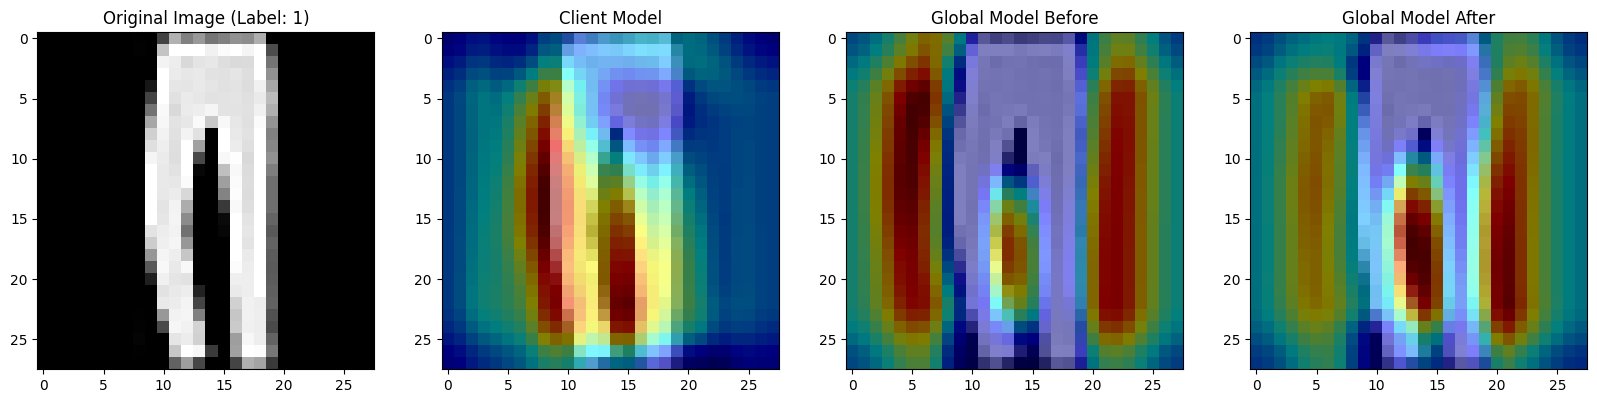

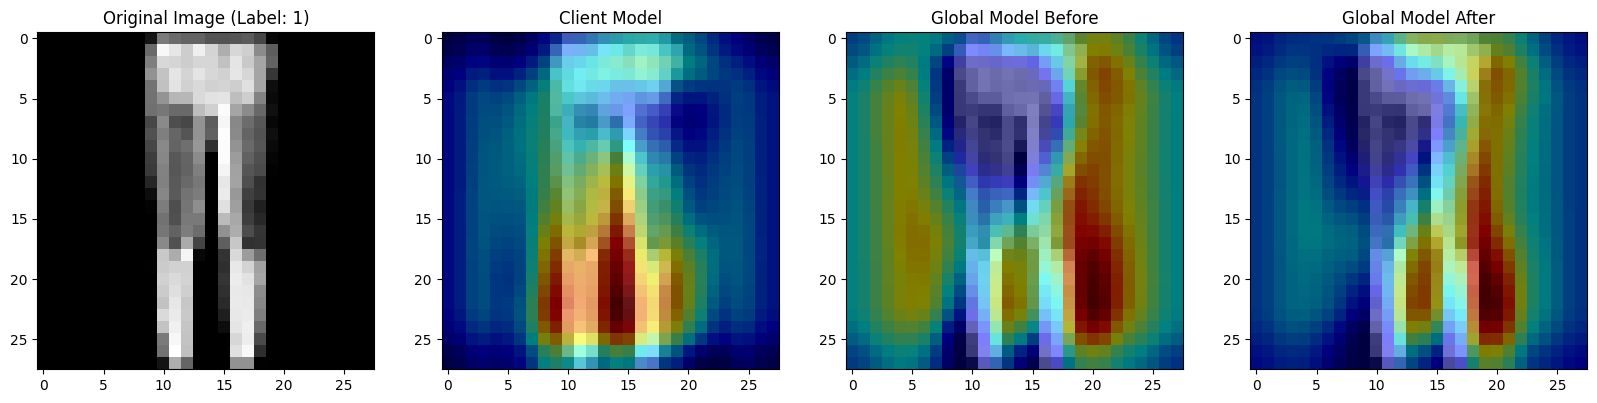

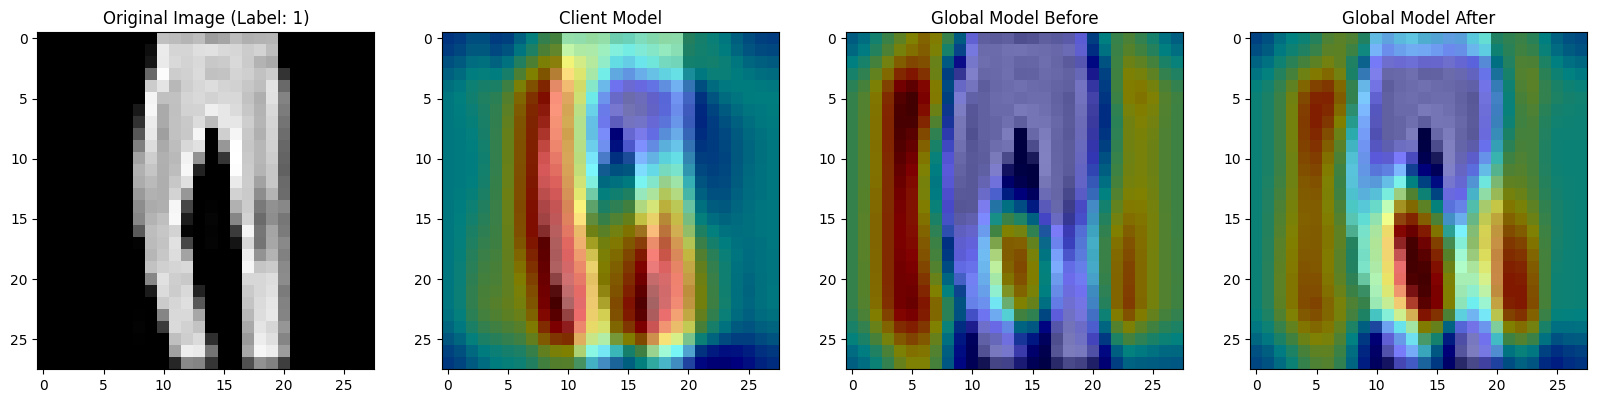

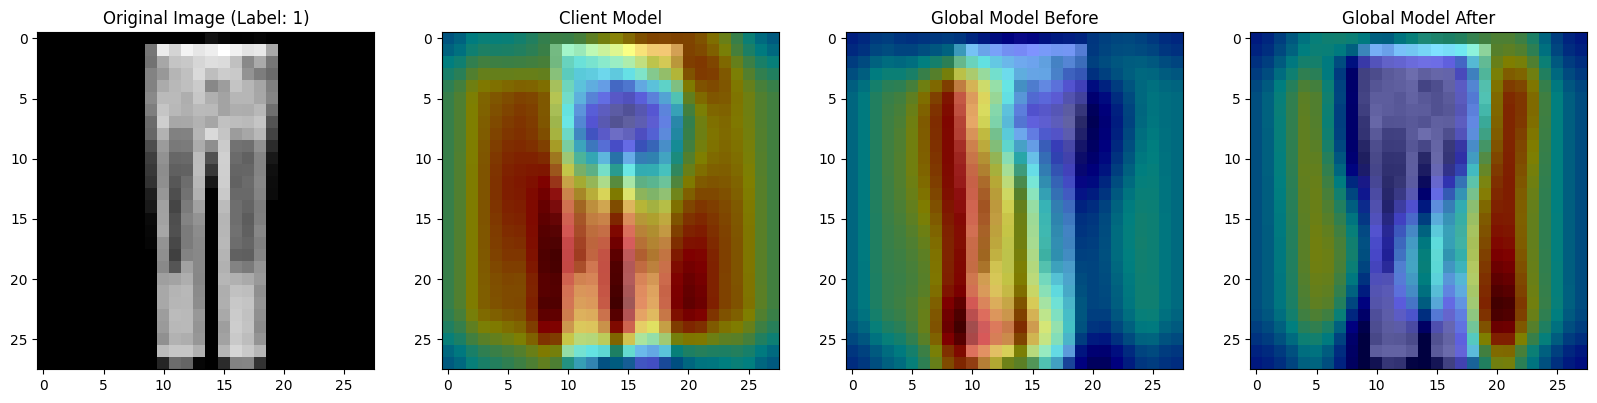

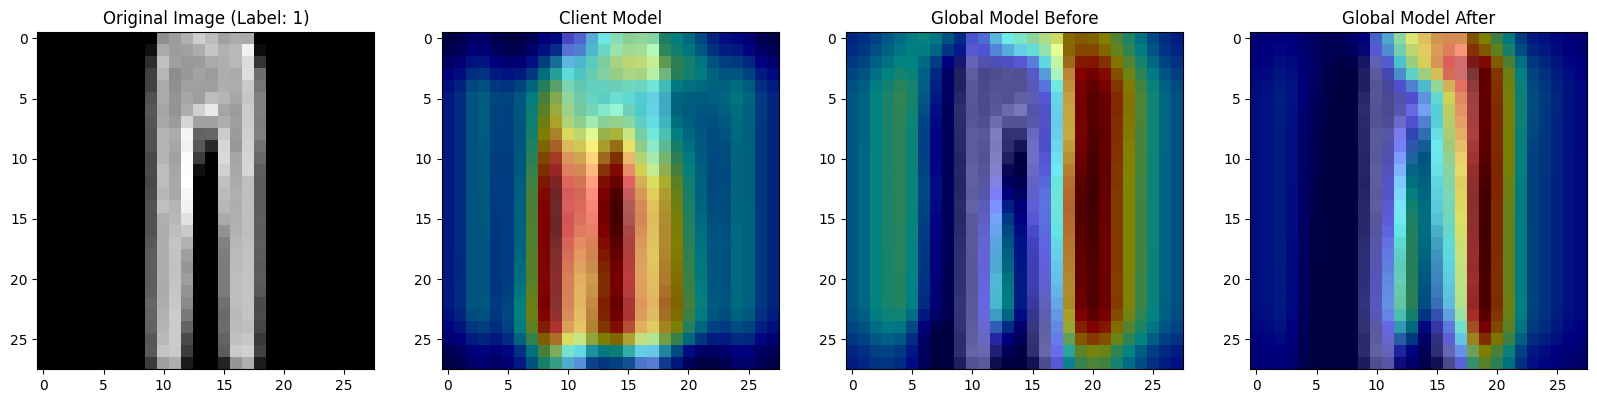

In [10]:
analytics.visualize_feature_comparison(client_idx=0, testDataloader=testDataloader, num_images_to_visualize=5, visualization_class=1)

In [11]:
analytics.display_classwise_metrics(0, testDataloader)


Class 0:
  Accuracy:
    Client Model:      ||||||||||||||||||||||||||---- (0.85)
    Global Before:     ||||||||||||||||||||||||||---- (0.83)
    Global After:      ||||||||||||||||||||||||||---- (0.85)
  Confidence:
    Client Model:      |||||||||||||||||||||||------- (0.76)
    Global Before:     ||||||||||||||||||||||-------- (0.70)
    Global After:      ||||||||||||||||||||||-------- (0.72)
---

Class 1:
  Accuracy:
    Client Model:      |||||||||||||||||||||||||||||| (0.98)
    Global Before:     |||||||||||||||||||||--------- (0.67)
    Global After:      ||||||||||||||||||||||||||---- (0.85)
  Confidence:
    Client Model:      |||||||||||||||||||||||||||||| (0.96)
    Global Before:     ||||||||||||||||||------------ (0.58)
    Global After:      ||||||||||||||||||||||||------ (0.79)
---

Class 2:
  Accuracy:
    Client Model:      ||||||||||||||||||||||||------ (0.77)
    Global Before:     ||||||||||||||||||||---------- (0.66)
    Global After:      |||||||||||||||||||||

In [12]:
analytics.display_feature_summary(0, testDataloader)


Class 0:
Client Model 0:                  ||||||||||||||||||||||-------- (0.0119)
Global Model Before Unlearning:  ||||||||||||||||||||---------- (0.0106)
Global Model After Unlearning:   |||||||||||||||||||||--------- (0.0113)

Class 1:
Client Model 0:                  ||||||||||||||||||||||||||---- (0.0138)
Global Model Before Unlearning:  |||||||||||||||||------------- (0.0090)
Global Model After Unlearning:   |||||||||||||||||||----------- (0.0104)

Class 2:
Client Model 0:                  ||||||||||||||||||------------ (0.0096)
Global Model Before Unlearning:  |||||||||||||||||------------- (0.0091)
Global Model After Unlearning:   |||||||||||||||||||----------- (0.0103)

Class 3:
Client Model 0:                  ||||||||||||||||-------------- (0.0085)
Global Model Before Unlearning:  ||||||||||||||||-------------- (0.0086)
Global Model After Unlearning:   ||||||||||||||||||||---------- (0.0104)

Class 4:
Client Model 0:                  ||||||||||||||||||||||||||---- (0.0141)
G

In [13]:
analytics.display_client_contributions_to_calss_compared_to_others(0, testDataloader, num_classes=10)


Class 0:
  Client 0 Model Accuracy:          ||||||||||||||||||||||||||---- (0.85) with 1000 samples
  Remaining Clients Model Accuracy: |||||||||||||||||||||||||----- (0.83) with 1000 samples
  Global Model Accuracy:            ||||||||||||||||||||||||||---- (0.83) with 1000 samples

Class 1:
  Client 0 Model Accuracy:          |||||||||||||||||||||||||||||| (0.98) with 1000 samples
  Remaining Clients Model Accuracy: ||||||||||||||||-------------- (0.53) with 1000 samples
  Global Model Accuracy:            |||||||||||||||||||||--------- (0.67) with 1000 samples

Class 2:
  Client 0 Model Accuracy:          ||||||||||||||||||||||||------ (0.77) with 1000 samples
  Remaining Clients Model Accuracy: ||||||||||||||||||||---------- (0.65) with 1000 samples
  Global Model Accuracy:            ||||||||||||||||||||---------- (0.66) with 1000 samples

Class 3:
  Client 0 Model Accuracy:          ||||||||||||||||||||||||------ (0.77) with 1000 samples
  Remaining Clients Model Accuracy: ||||

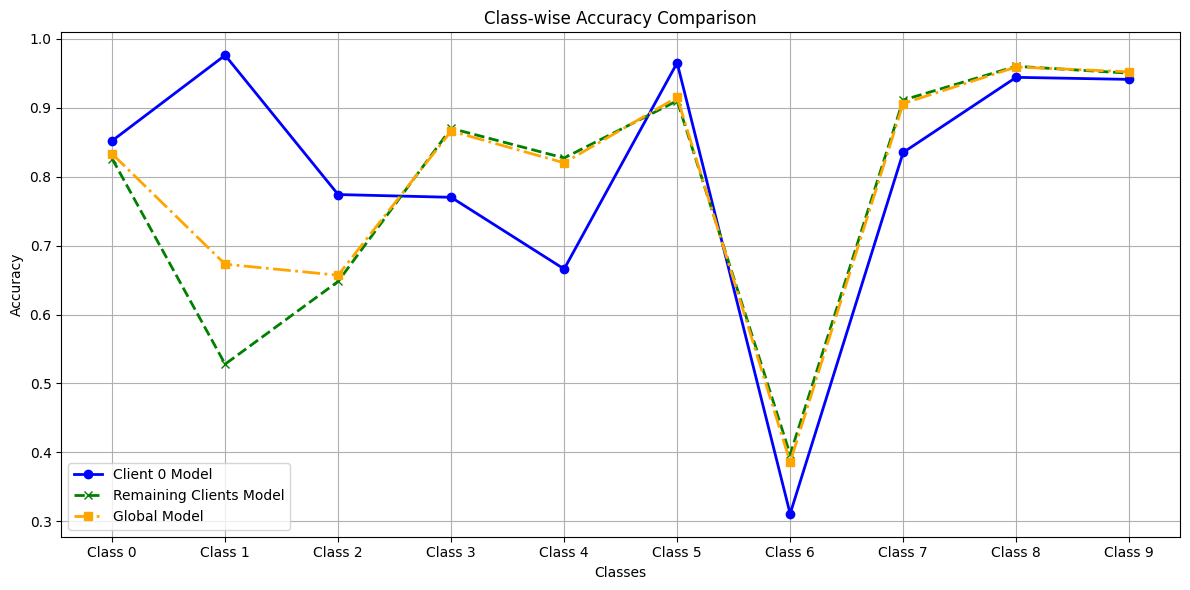

In [14]:
analytics.plot_client_contributions_to_calss_compared_to_others(0, testDataloader, num_classes=10)

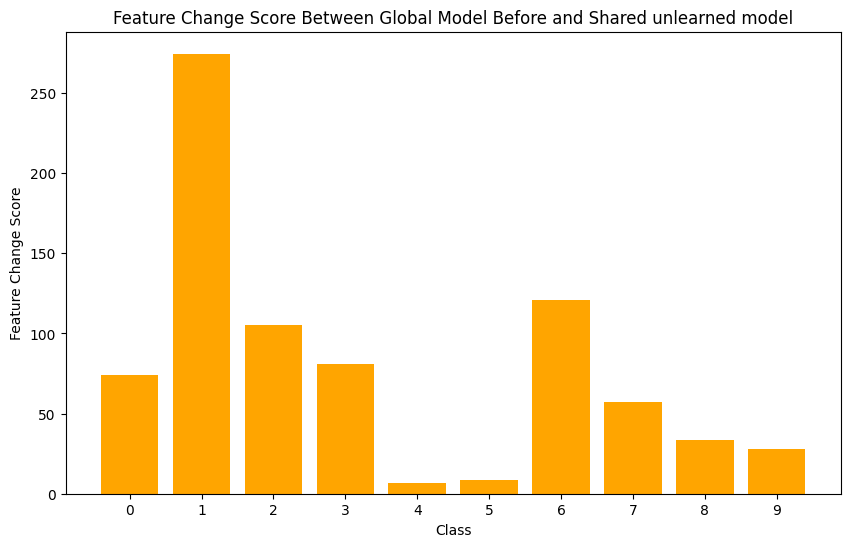

In [19]:
analytics.visualize_feature_change_class_wise_shared_unlearned_model(client_idx=0, testDataloader=testDataloader)

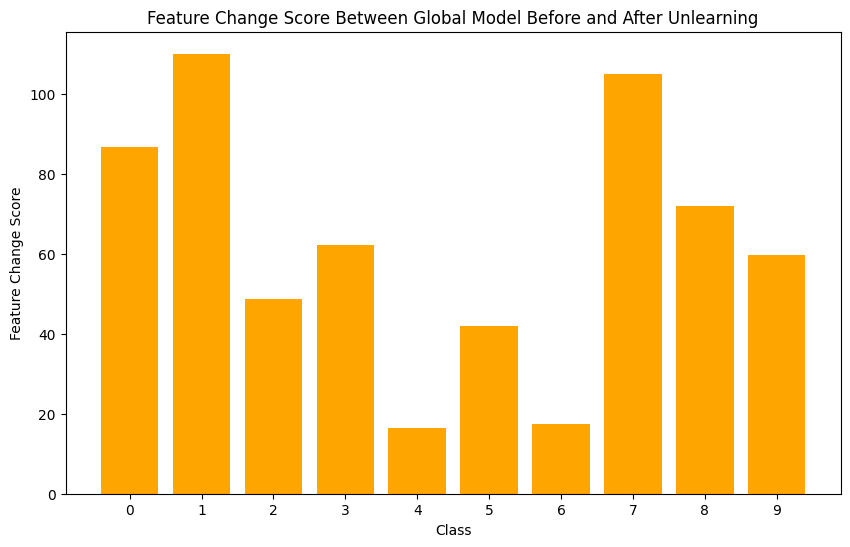

In [16]:
analytics.visualize_feature_change_class_wise(client_idx=0, testDataloader=testDataloader)

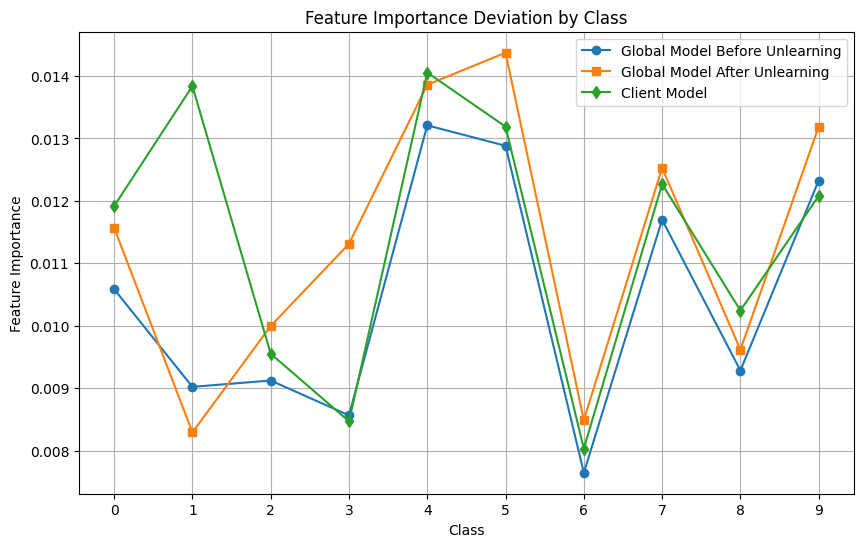

In [17]:
analytics.plot_mean_feature_deviation(client_idx=0, test_loader=testDataloader)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


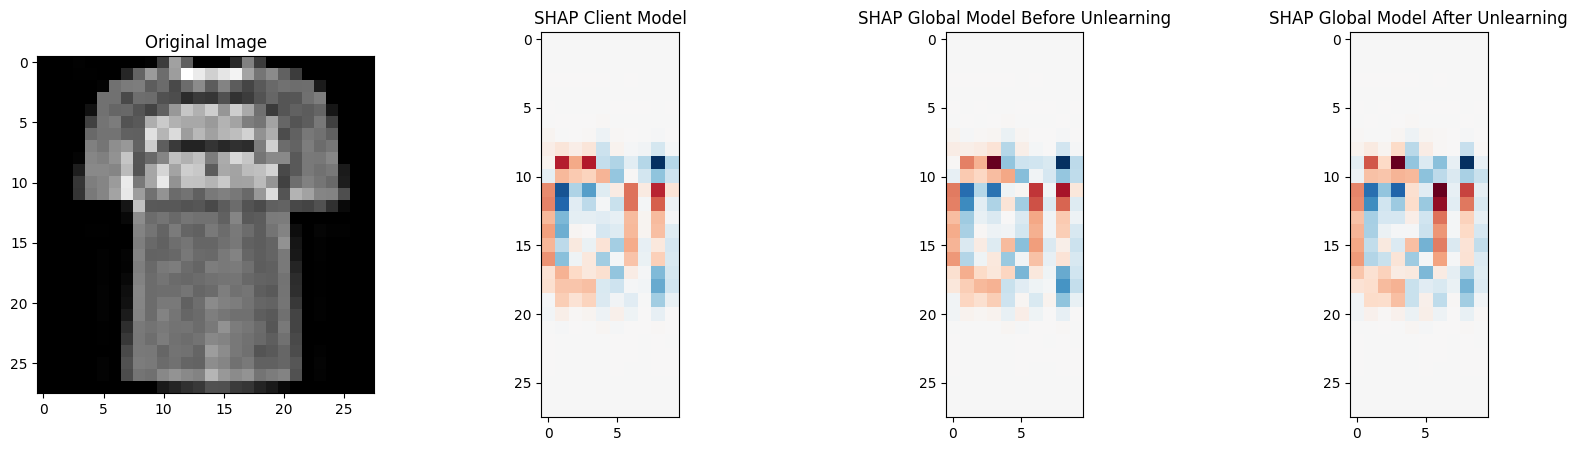

In [18]:
%load_ext autoreload
%autoreload 2

analytics = Analytics(cache)
analytics.plot_shap_comparison(0, testDataloader)